======================================================================================================

**Disclaimer**: Parts of this notebook are adapted from this [**Kaggle Notebook**](https://www.kaggle.com/code/scratchpad/notebook07bfbd481c/edit)  with minor modifications. Credit to the original authors.

======================================================================================================

# Workshop 3
## Find an Optimal Policy with Value Based Methods

In this series of Jupyter notebooks, we will delve into various methods for finding an optimal policy within the context of Finite Markov Decision Processes (MDPs).

## Methods Overview
The series is structured into three parts, each focusing on a different approach for solving MDPs:

**Part 1: Dynamic Programming ([link](https://www.kaggle.com/minaiyuki/solving-mdp-using-dynamic-programming))**

**Part 2: Monte Carlo Methods ([link](https://www.kaggle.com/minaiyuki/solving-mdp-using-monte-carlo-methods))**

**Part 3: TD Learning (This notebook)**

# Part 3: TD-learning

## (Review) What is a Markov Decision Process (MDP)?

In the field of Reinforcement Learning (RL), Markov Decision Processes (MDPs) are fundamental mathematical models used for decision-making in dynamic environments. An MDP consists of several key components:

- **States (S)**: Possible situations or configurations within the environment.

- **Actions (A)**: A set of choices or decisions that an agent can make.

- **Transitions (T)**: Rules or probabilities governing how the environment moves from one state to another after taking a specific action.

- **Rewards (R)**: Immediate numerical values that indicate the desirability of an agent's actions.

- **Discount Factor (γ)**: A factor that balances immediate rewards against future rewards.

The key characteristic of an MDP is that the future state and reward depend only on the current state.


In the [last notebook](https://www.kaggle.com/minaiyuki/solving-mdp-using-monte-carlo-methods), we learned Monte Carlo (MC) methods to solve the prediction problem, where we estimate the value function associated with a specific policy, and the control problem, where we aim to discover an optimal policy, through interactions with the environment. A distinguishing characteristic of MC methods lies in their reliance on sampled returns observed during these interactions to update the value function. As a consequence of this requirement, each episode must reach its terminal before any learning can take place. Learning only occurs after the completion of an episode.

However, do we really have to wait until the end of the episode? Are there more efficient methods for acquiring knowledge about the value function and policy? In particular, can we acquire knowledge during an episode or even when an episode is not yet terminated? In this notebook, we will explore the answers to these questions by introducing the concept of Temporal Difference (TD) learning.

___

In [ ]:
!pip install gymnasium[toy_text]

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import LEFT, RIGHT, DOWN, UP
import seaborn as sns
from IPython.display import clear_output


# Prepare Frozen Lake environment

As in the last two notebooks, we will use the frozen lake environment in gymnasium.


[Learn more about the Frozen Lake environment](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

The objective of this environment is for an agent to navigate through a grid world, starting from the initial cell and reaching the goal cell. Here, we are using a 4x4 grid map, and each cell falls into one of four different categories:

- **S (Start)**: This cell is where our agent begins its journey.

- **F (Frozen)**: These cells are safe for the agent to walk on.

- **H (Hole)**: These are hazardous cells, and if the agent falls into one, the episode terminates with a reward of 0.

- **G (Goal)**: Reaching this cell yields a reward of +1 for the agent.

From the starting cell, the agent has the option to move in four directions: up, left, down, or right. The agent's task is to explore the grid world, making decisions at each time step to eventually reach the goal cell and collect a reward of +1.

In the below code, we can see an example of the agent randomly exploring this environment over 100 time steps.


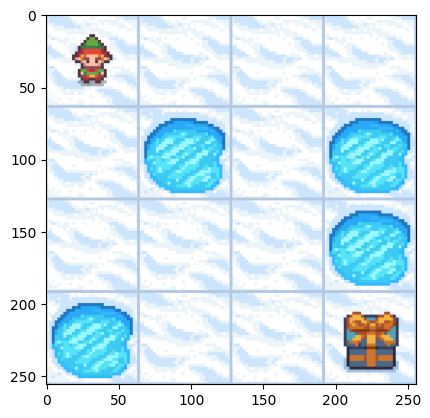

In [ ]:
# Create the FrozenLake environment with specific settings
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False, render_mode="rgb_array")

# Reset the environment to its initial state and get the initial observation (initial state)
observation, info = env.reset(seed=2023)
num_state = env.observation_space.n
num_action = env.action_space.n

# Simulate the agent's actions for 100 time steps
for _ in range(100):
    # Choose a random action from the action space
    action = env.action_space.sample()

    # Take the chosen action and observe the resulting state, reward, and termination status
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode is terminated, reset the environment to the start cell
    if terminated:
        observation, info = env.reset()

    # Display the current state of the environment
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

env.close()


## TD(0)

As we discussed briefly in the introduction, TD-learning is a method that acquires state/action values through experiential learning. Instead of relying on sampled returns, it utilizes estimated state/action values in future states to update the current state/action values. This technique, known as $bootstrapping$, is achieved through the following update formula:

$$V(S_t) = V(S_t) + \alpha(R_{t+1} + \gamma V(S_{t+1}) - V(S_t))$$

Here, $V(S_t)$ represents the state value for the current state $S_t$, $\alpha$ denotes the step size or learning rate, $R_{t+1}$ stands for the immediate reward at the next state, $\gamma$ is the discount factor for future rewards, and $V(S_{t+1})$ represents the state value at the subsequent state $S_{t+1}$.

The term $R_{t+1} + \gamma V(S_{t+1})$ informs us about the value of the current state as the summation of the immediate reward and the discounted state value at the next state(i.e the expected total reward after state $S_{t+1}$.

$R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$ is referred to as the TD-error, which quantifies the difference between the estimated value of $S_t$ and the expected value $R_{t+1} + \gamma V(S_{t+1})$.

It's important to note that, in contrast to MC methods, which use the average of the actual sampled return $G$ after visiting a state, TD-learning incorporates the state value of the next state in the update of the current state value.

Now, let's learn the detailed of the algorithm. Below, you can find the pseudo-code for TD-learning, which is employed to estimate the state value function under a policy $\pi$.


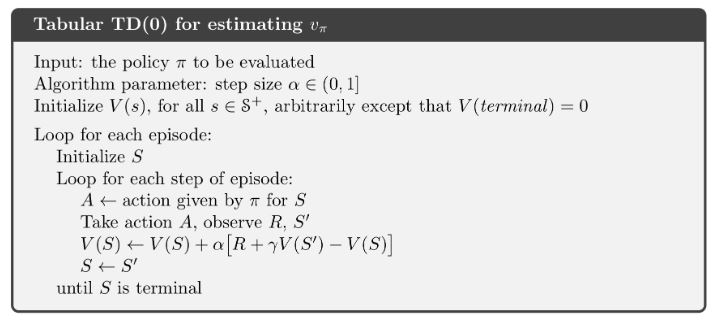

It's worth noting that, since we use the sampled reward $R$ at a next time step in our update process, this update occurs after taking a step from state $S$ and observing the next state $S'$ and reward $R$.

This TD-learning method is referred to as TD(0) or one-step TD because it solely utilizes the immediate reward at the next step, denoted as $R$. TD(1), on the other hand, incorporates not only the immediate reward at the next state but also the reward one step further, resulting in the following update formula:
$
V(S_t) = V(S_t) + \alpha(R_{t+1} + \gamma R_{t+2} + \gamma^2 V(S_{t+2}) - V(S))
$

To execute this update, one must wait the observation of the next two rewards. Likewise, TD($\infty$) requires waiting until the end of an episode and does not make use of the next state value. In fact, this corresponds to the Monte Carlo (MC) method, which relies on the entire history of sampled rewards for state/action value updates.

From a mathematical perspective, we can express the following relationship for the value function estimate:

$
v_{\pi}(s) \doteq \mathbb{E}[G_t|S_t=s] =  \mathbb{E}[R_{t+1} + \gamma G_{t+1}|S_t=s] =  \mathbb{E}[R_{t+1} + \gamma v_{\pi}(S_{t+1})|S_t=s]
$

MC methods employ an estimate of the first expression with $G_t$ as the target, whereas TD learning (as well as Dynamic Programming) utilizes an estimate of the last expression with $R_{t+1}$ and $v_{\pi}(S_{t+1})$ as the target.

Similar to MC methods, for any fixed policy $\pi$, TD(0) exhibits asymptotic convergence to $v_{\pi}$ provided that a constant step-size parameter is sufficiently small. With a decreasing step-size parameter following the usual schedule, TD(0) converges with a probability of 1.


Now, let's see the implementation of the above TD(0) for estimating the state values.

In [ ]:
def td_policy_evaluation(env, policy, value_func, step_size=0.1, gamma=0.9, num_episode=1000, plot_heatmap=False):
    """
    Run TD-learning policy evaluation to estimate state values.
    """
    for i in range(num_episode):
        # Initialize
        state, _ = env.reset()
        terminated = False

        while not terminated:
            # Choose an action according to the policy
            action = np.random.choice(env.action_space.n, p=np.squeeze(policy[state]))

            # Take a step
            next_state, reward, terminated, truncated, info = env.step(action)

            # Update value function
            value_func[state] = value_func[state] + step_size * (reward + gamma * value_func[next_state] - value_func[state])

            # Update state
            state = next_state

        if plot_heatmap:
            if i % 200 == 0:
                plot_value_func_heatmap(env, value_func, eps_ind=i)

    if plot_heatmap:
        plot_value_func_heatmap(env, value_func)

    return value_func


def plot_value_func_heatmap(env, value_func, eps_ind=None):
    """
    Plot a heatmap of the value function.
    """
    env = env.unwrapped
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(np.reshape(value_func, [env.nrow, env.ncol]),
                annot=True, linewidths=.5, cmap="GnBu_r", ax=ax,
                yticklabels=np.arange(1, env.nrow + 1)[::-1],
                xticklabels=np.arange(1, env.nrow + 1),
                vmin=0, vmax=1)
    if eps_ind is None:
        plt.title('State value heatmap', fontsize=15)
    else:
        plt.title(f"State value heatmap, Episode:{eps_ind}", fontsize=15)
    plt.show()


def display_policy_letters(env, policy):
    """
    Display the policy in letter format.
    """
    env = env.unwrapped
    action_arrows = {LEFT: '←', RIGHT: '→', DOWN: '↓', UP: '↑'}
    policy_letters = []
    for l in policy:
        policy_letters.append(action_arrows[l][0])

    policy_letters = np.array(policy_letters).reshape(env.nrow, env.ncol)

    for row in range(env.nrow):
        print(''.join(policy_letters[row, :]))


Let's check the estimated state values for one of the optimal $\epsilon$ greedy policy.

Optimal Policy for evaluating the state value:
↓→↓←
↓←↓←
→↓↓←
←→→←


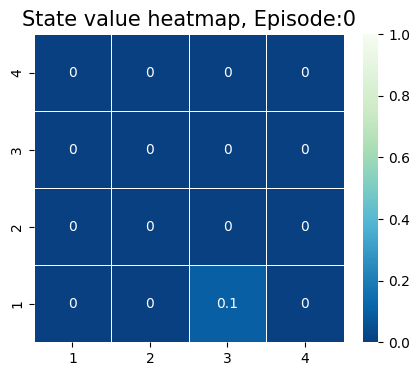

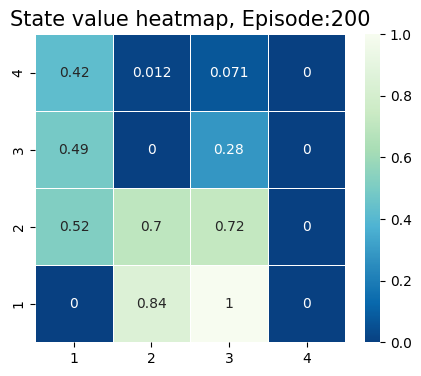

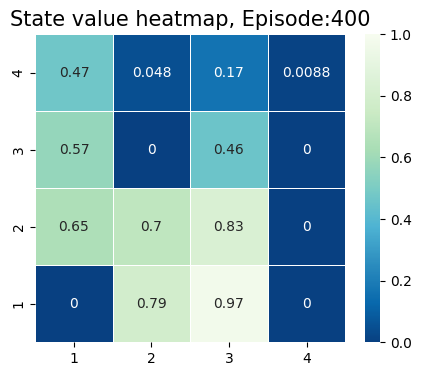

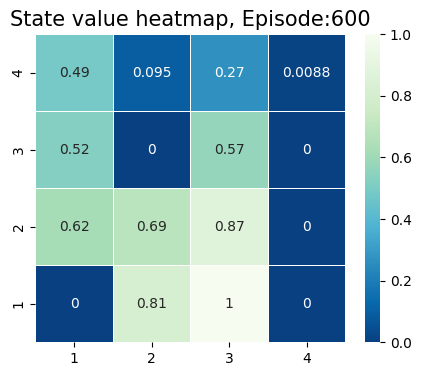

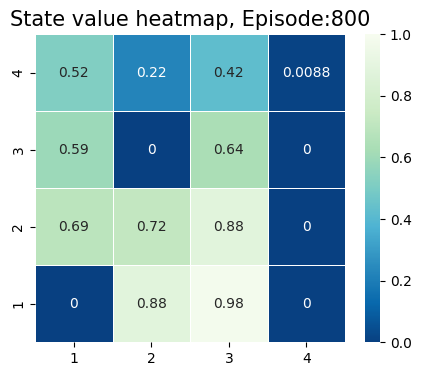

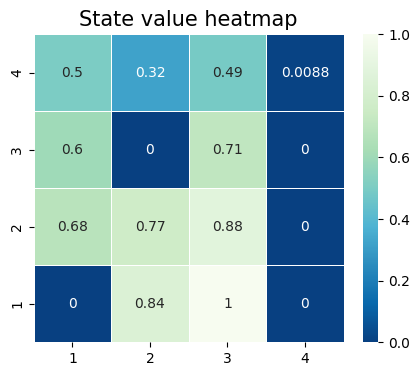

In [ ]:
# Set the step size and epsilon values
step_size = 0.1
epsilon = 0.1

# Initialize the value function and the list of possible actions
value_func = np.zeros(num_state)
action_list = np.arange(0, num_action)

# Initialize an epsilon-greedy policy
epsilon = 0.1
policy = np.zeros([num_state, num_action])
optimal_actions = [1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0]
for state in range(num_state):
    for action in range(num_action):
        if action == optimal_actions[state]:
            policy[state][action] = 1 - epsilon + 1 / num_action * epsilon
        else:
            policy[state][action] = 1 / num_action * epsilon

print('Optimal Policy for evaluating the state value:')
display_policy_letters(env, optimal_actions)

# Perform TD-learning for policy evaluation
value_func = td_policy_evaluation(env, policy, value_func, step_size=step_size, num_episode=1000, plot_heatmap=True)


The learned state values demonstrate that cells closer to the goal have higher values than those farther from the goal, which aligns with our expectations regarding value estimation because we have the discount factor. Thus, we can effectively estimate state values using TD-learning.


## On-policy TD control (SARSA)

Now, let's consider how to learn the optimal policy using TD-learning. As we discussed in the last notebook, there are two fundamental approaches for learning the optimal policy through interactions with the environment: on-policy and off-policy methods.

The on-policy method employs a single policy for both behaving in the environment and defining the optimal policy. In contrast, the off-policy method utilizes two distinct policies. It employs a behavior policy to interact with the environment and learns a target policy to optimize behavior.

TD-learning can be employed with both of these approaches. Let's begin by examining the on-policy TD control scenario, particularly focusing on SARSA (State-Action-Reward-State-Action).

It's essential to remember that when the environment's dynamics are unknown, and the agent must learn through interaction with the environment, simply learning state-action values isn't sufficient to determine the optimal policy. This is because even if we know the state value, we lack the knowledge of how to reach that state without understanding the dynamics. Instead, our objective is to estimate action values to identify the optimal policy. By learning the action values, we can define our policy by taking an action with the max value at each state.

The update formula for action values with SARSA closely resembles that for state values, but we replace the state value estimate, represented as $V$, with the action value estimate, denoted as $Q$:

$$Q(S_t, A_t) = Q(S_t, A_t) + \alpha(R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t))$$

If $S_{t+1}$ is a terminal state, then $Q(S_{t+1}, A_{t+1})$ is defined as zero.

Below is the pseudocode for implementing SARSA to estimate action values.


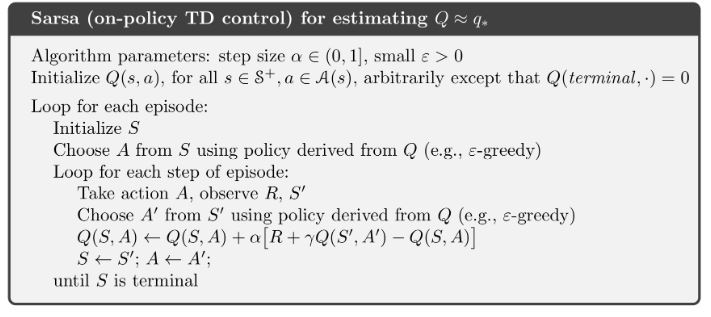

Since SARSA is an on-policy method, it uses a single policy derived from the action value function Q. This policy is used to make action choices and update the Q-values.

Unlike Monte Carlo (MC) methods, SARSA (a TD-learning method) updates action values without waiting for the episode termination. For instance, if a policy were to trap the agent in the same state, an episode would never end and no value update happens in the case of MC methods. However, TD-learning methods like SARSA don't encounter this issue. They quickly learn during the episode, recognizing that such policies are suboptimal and switching to alternative strategies.

Let's see the implementation of SARSA.

In [ ]:
def sarsa(env, value_func, step_size=0.1, epsilon=0.1, gamma=0.9, num_episode=1000):
    """
    Run SARSA to estimate action values
    """
    for i in range(num_episode):
        # Initialization
        state, _ = env.reset()
        terminated = False

        # Choose an action with epsilon-greedy policy
        action = choose_epsilon_greedy_action(env, state, value_func, epsilon)

        while not terminated:
            # Take a step
            next_state, reward, terminated, truncated, info = env.step(action)

            # Choose the next action with epsilon-greedy policy (A')
            next_action = choose_epsilon_greedy_action(env, next_state, value_func, epsilon)

            # Update the action value function
            value_func[state][action] = value_func[state][action] + step_size * (reward + gamma * value_func[next_state][next_action] - value_func[state][action])

            # Update the current state and action
            state = next_state
            action = next_action

    return value_func

def choose_epsilon_greedy_action(env, state, value_func, epsilon):
    """
    Choose an action based on an epsilon-greedy policy.
    """
    p = np.random.random()  # Generate a random number in the range (0, 1).
    if p < epsilon:
        action = np.random.choice(env.action_space.n) # Random action
    else:
        action_values_at_s = value_func[state]
        greedy_actions = np.where(action_values_at_s == np.max(action_values_at_s))[0] # Handle ties
        action = np.random.choice(greedy_actions) # Greedy action
    return action


Text(0.5, 1.0, 'Action values at state (x,y)=(3,2)')

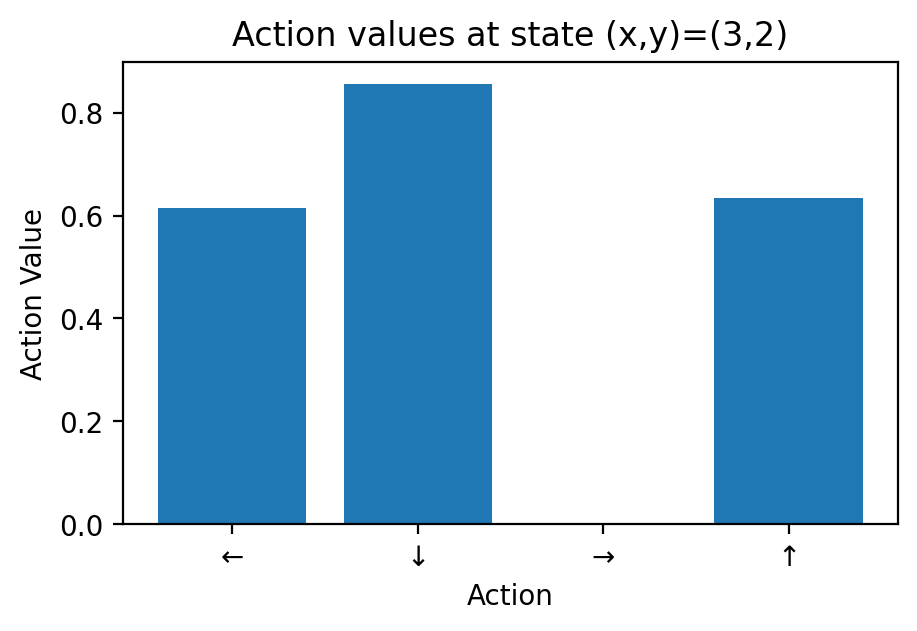

In [ ]:
# Set step size and epsilon
step_size = 0.1
epsilon = 0.1

# Initialize the action value function
value_func = np.zeros([num_state, num_action])
action_list = np.arange(0, num_action)

# Run SARSA to estimate the action values
value_func = sarsa(env, value_func, step_size=step_size, epsilon=epsilon, num_episode=10000)

# Plot action values at state (x,y)=(3,2) cell
plt.figure(figsize=(5, 3), dpi=200)
plt.bar(['←', '↓', '→', '↑'], value_func[10]) # (x,y)=(3,2)
plt.xlabel('Action')
plt.ylabel('Action Value')
plt.title('Action values at state (x,y)=(3,2)')


In the above code, we plot the learned action values for state (3,2) as an example. In this cell, the optimal action is to move downward. Moving right is considered the least favorable action due to the presence of a hole. Moving up and left take the agent away from the goal, making it a suboptimal choice. The learned action values reflect these expectations.


## Q-learning

Next, we learn off-policy TD learning, a method known as Q-learning. Q-learning is an off-policy learning approach that employs two distinct policies: a behavior policy and a target policy.

Just as a reminder, as we discussed in the last notebook, in order to learn the optimal policy through the interaction with the environment, we must visit all states many times. This requires the exploration of all states with our behavior policy, which results in an opportunity loss as we continue exploring actions even after identifying the optimal actions for each state.

Off-policy methods address this challenge by employing two different policies.

Below is the presude code of Q-learning.


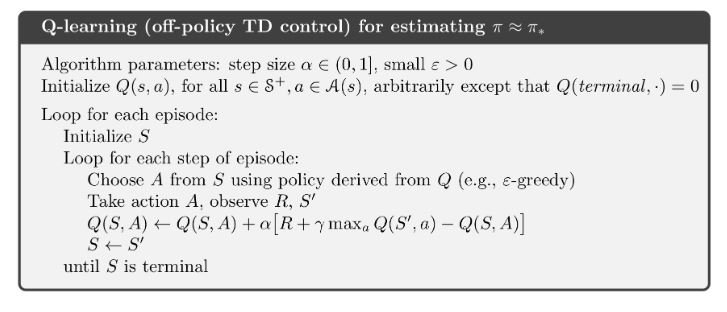

In this presude code, a behavior policy is a soft policy such as epsilon greedy. Our target policy is the greedy policy as we can see $\max$ in Q-value update formula. We choose an action which has max action value at the next state $S'$. This update equation is basically the same as SARSA except this $max$ term. This $max$ term makes Q-learning an off-policy learning method.

SARSA
$$Q(S_t, A_t) = Q(S_t, A_t) + \alpha(R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t))$$

Q-learning
$$Q(S_t, A_t) = Q(S_t, A_t) + \alpha(R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t))$$

 Let's see the implementation of Q-learning with this update equation.

In [ ]:
def q_learning(env, value_func, step_size=0.1, epsilon=0.1, gamma=0.9, num_episode=1000):
    """
    Run Q-learning to estimate action values
    """
    for i in range(num_episode):
        # Initialization
        state, _ = env.reset()
        terminated = False

        while not terminated:
            # Choose an action with epsilon-greedy policy
            action = choose_epsilon_greedy_action(env, state, value_func, epsilon)

            # Take a step
            next_state, reward, terminated, truncated, info = env.step(action)

            # Choose the next action with a greedy policy (A')
            next_action = choose_greedy_action(env, next_state, value_func, epsilon)

            # Update the action value function
            value_func[state][action] = value_func[state][action] + step_size * (reward + gamma * value_func[next_state][next_action] - value_func[state][action])

            # Update the current state and action
            state = next_state
            action = next_action

    return value_func


def choose_greedy_action(env, state, value_func, epsilon):
    """
    Choose an action based on an greedy policy.
    """
    action_values_at_s = value_func[state]
    greedy_actions = np.where(action_values_at_s == np.max(action_values_at_s))[0] # Handle ties
    action = np.random.choice(greedy_actions) # Greedy action

    return action


Text(0.5, 1.0, 'Action values at state (x,y)=(3,2)')

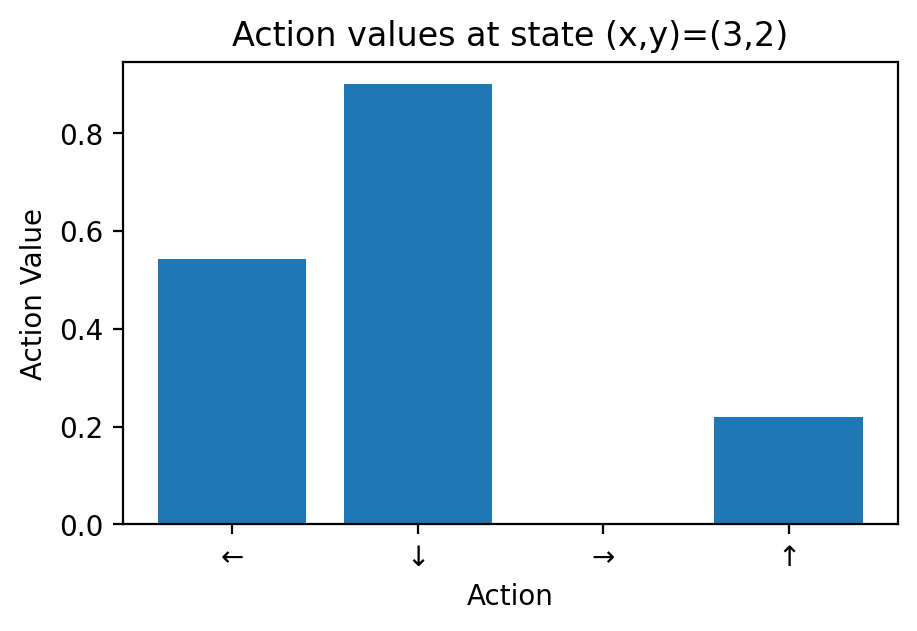

In [ ]:
# Set step size and epsilon
step_size = 0.1
epsilon = 0.1

# Initialize the action value function
value_func = np.zeros([num_state, num_action])
action_list = np.arange(0, num_action)

# Run SARSA to estimate the action values
value_func = q_learning(env, value_func, step_size=step_size, epsilon=epsilon, num_episode=10000)

# Plot action values at state (x,y)=(3,2) cell
plt.figure(figsize=(5, 3), dpi=200)
plt.bar(['←', '↓', '→', '↑'], value_func[10]) # (x,y)=(3,2)
plt.xlabel('Action')
plt.ylabel('Action Value')
plt.title('Action values at state (x,y)=(3,2)')


The above code is exactly the same as SARSA implemnetation except the update equation. The learned action values by Q-learning also reflect our expectations.

## Summary

In this notebook, we reviewed TD-learning for solving Markov Decision Processes (MDPs). The key difference between MC methods and TD-learning is the value update strategy. While MC methods use the average of sampled return to estimate the value function, TD-learning uses the estimate of the future state value to estimate the value of the current state. TD-learning's advantage lies in its ability to promptly learn during an episode without waiting for its termination, as it doesn't hinge on sampled returns. However, this agility comes at the cost of potential noise, leading to quick changes in decisions.


## Ref

- Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.
